In [1]:
import cv2
import numpy as np
import os
from datetime import timedelta
from numpy.linalg import norm, inv
from scipy.stats import multivariate_normal as mv_normal
from PIL import Image as im
import math

In [2]:
# Getting data from git repo
!git clone https://github.com/MannJain1609/Real-Time-Object-Tracking.git
%cd Real-Time-Object-Tracking

Cloning into 'Real-Time-Object-Tracking'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
/content/Real-Time-Object-Tracking


In [3]:
def get_frames_durations(cap, saving_fps):
    """A function that returns the list of durations where to save the frames"""
    s = []
    # get the video duration by dividing number of frames by the number of frames per second
    vid_duration = cap.get(cv2.CAP_PROP_FRAME_COUNT) / cap.get(cv2.CAP_PROP_FPS)
    # use np.arange() to make floating-point steps
    for i in np.arange(0, vid_duration, 1 / saving_fps):
        s.append(i)
    return s

In [4]:
video_file = "/content/Real-Time-Object-Tracking/Video File/VID_MJ.mp4"

In [5]:
def format_timedelta(td):
    """Utility function to format timedelta objects (e.g 00:00:20.05) 
    omitting microseconds and retaining milliseconds"""
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return (result + ".00").replace(":", "-")
    ms = int(ms)
    ms = round(ms / 1e4)
    return f"{result}.{ms:02}".replace(":", "-")

In [6]:
file_name = "Frames"
import shutil

if os.path.isdir(file_name):
  shutil.rmtree(file_name)


In [7]:
SAVING_FRAMES_PER_SECOND = 10
frames = []

if not os.path.isdir(file_name):
  os.mkdir(file_name)
# read the video file    
cap = cv2.VideoCapture(video_file)
# get the FPS of the video
fps = cap.get(cv2.CAP_PROP_FPS)
print("FPS: ", fps)
# if the SAVING_FRAMES_PER_SECOND is above video FPS, then set it to FPS (as maximum)
saving_frames_per_second = min(fps, SAVING_FRAMES_PER_SECOND)
# get the list of duration spots to save
saving_frames_durations = get_frames_durations(cap, saving_frames_per_second)
# start the loop
frame_count = 0
count = 0
while True:
  is_read, frame = cap.read()
  if not is_read:
    # break out of the loop if there are no frames to read
    break
  # get the duration by dividing the frame count by the FPS
  frame_duration = frame_count / fps
  try:
    # get the earliest duration to save
    closest_duration = saving_frames_durations[0]
  except IndexError:
      # the list is empty, all duration frames were saved
      break
  if frame_duration >= closest_duration:
    # if closest duration is less than or equals the frame duration, 
    # then save the frame
    frame_duration_formatted = format_timedelta(timedelta(seconds=frame_duration))
    img = im.fromarray(frame)
    img = img.resize((140,100), im.ANTIALIAS)
    frame = np.array(img)
    cv2.imwrite(os.path.join(file_name, f"frame{frame_duration_formatted}.jpg"), frame) 
    frames.append(frame)

    count += 1
    # drop the duration spot from the list, since this duration spot is already saved
    try:
        saving_frames_durations.pop(0)
    except IndexError:
        pass
  # increment the frame count
  frame_count += 1
frames = np.array(frames)

FPS:  10.0


In [8]:
print("Number of frames in directory is {}".format(count))

Number of frames in directory is 28


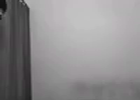

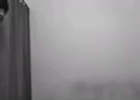

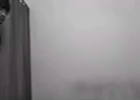

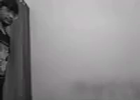

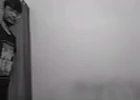

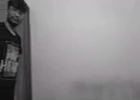

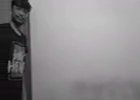

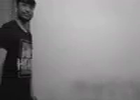

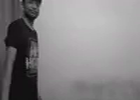

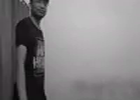

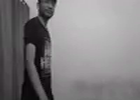

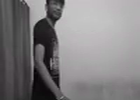

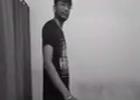

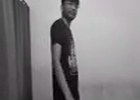

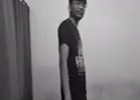

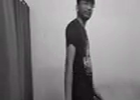

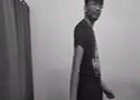

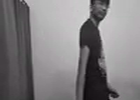

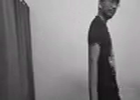

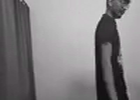

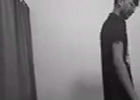

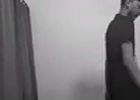

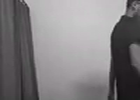

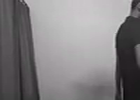

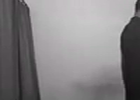

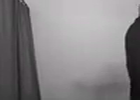

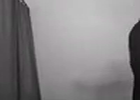

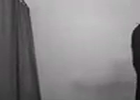

In [9]:
for i in range(count):
  data = im.fromarray(frames[i])
  display(data)
  print()

In [10]:
print("array dimensions will be (num_frames, image_width, image_height)")
print("Shape of frames is {}".format(frames.shape))

array dimensions will be (num_frames, image_width, image_height)
Shape of frames is (28, 100, 140, 3)


In [11]:
def is_match(pixel,mean,sigma):
  '''
  check whether a pixel match a Gaussian distribution. Matching means pixel is less than
  2.5 standard deviations away from a Gaussian distribution.
  '''
  x = np.mat(np.reshape(pixel, (3, 1)))
  u = np.mat(mean).T
  sigma = np.mat(sigma)
  # calculate Mahalanobis distance
  d = np.sqrt((x-u).T*sigma.I*(x-u))
  if d < 2.5:
      return True
  else:
      return False

In [12]:
ROW,COL,RGB = frames[0].shape
print(ROW,COL)
num_frames = frames.shape[0]

100 140


In [13]:
#Gaussian Mixture Models Algorithm

K = 4
threshold = 0.9
init_weights = [0.8, 0.01, 0.1, 0.09]
init_mean = np.zeros(3)
# initial Covariance matrix
init_sigma = 255*np.eye(3)
init_alpha = 0.1

weights = np.array([[init_weights for j in range(COL)] for i in range(ROW)])
mean = np.array([[[init_mean for k in range(K)] for j in range(COL)]
                             for i in range(ROW)])
sigma = np.array([[[init_sigma for k in range(K)] for j in range(COL)]
                             for i in range(ROW)])

B = np.ones((ROW,COL),dtype=int)
alpha = init_alpha
#Initializing the distribution for pixels for the first image, taking mean = pixel value
for i in range(ROW):
  for j in range(COL):
      for k in range(K):
          mean[i][j][k] = np.array(frames[0][i][j]).reshape(1,3)

for f in range(1,num_frames,1):
  img = frames[f]
  for i in range(ROW):
    for j in range(COL):
        # Check whether match the existing K Gaussian distributions
        match = -1
        for k in range(K):
            if is_match(img[i][j], mean[i][j][k], sigma[i][j][k]):
                match = k
                mu = mean[i][j][k]
                sig = sigma[i][j][k]
                x = img[i][j].astype(float)
                delta = x - mu
                rho = alpha * mv_normal.pdf(img[i][j], mu, sig)
                weights[i][j] = (1 - alpha) * weights[i][j]
                weights[i][j][k] += alpha
                mean[i][j][k] = mu + rho * delta
                sigma[i][j][k] = sig + rho * (np.matmul(delta, delta.T) - sig)
        # if none of the K distributions match the current value
        # the least probable distribution is replaced with a distribution
        # with current value as its mean, an initially high variance and low rior weight
        if match == -1:
            w_list = [weights[i][j][k] for k in range(K)]
            id = w_list.index(min(w_list))
            # weight keep same, replace mean with current value and set high variance
            mean[i][j][id] = np.array(img[i][j]).reshape(1, 3)
            sigma[i][j][id] = np.array(init_sigma)
  #Reordering in descending order of (weight/sigma)
  '''
  reorder the estimated components based on the ratio pi / the norm of standard deviation.
  the first B components are chosen as background components
  '''
  for i in range(ROW):
      for j in range(COL):
          k_weight = weights[i][j]
          k_norm = np.array([norm(np.sqrt(sigma[i][j][k])) for k in range(K)])
          ratio = k_weight/k_norm
          descending_indices = np.argsort(-ratio)

          weights[i][j] = weights[i][j][descending_indices]
          mean[i][j] = mean[i][j][descending_indices]
          sigma[i][j] = sigma[i][j][descending_indices]

          cum_weight = 0
          T = threshold
          for index in range(K):
              cum_weight += weights[i][j][index]
              if cum_weight > T:
                  B[i][j] = index + 1
                  break

In [14]:
results = []
for ind in range(num_frames):
  img = frames[ind]
  result = np.array(img)
  for i in range(ROW):
    for j in range(COL):
        for k in range(B[i][j]):
            if is_match(img[i][j], mean[i][j][k], sigma[i][j][k]):
                # [255, 255, 255] is white, the background color will be set to white
                result[i][j] = [0,0,0]
                break
  results.append(result)

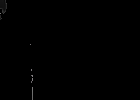

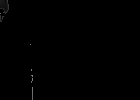

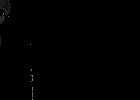

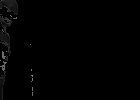

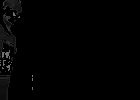

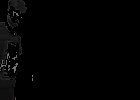

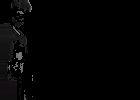

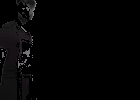

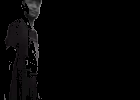

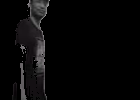

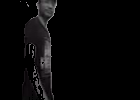

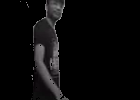

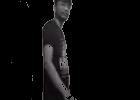

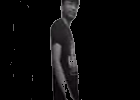

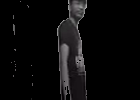

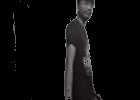

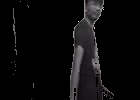

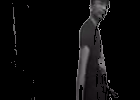

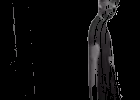

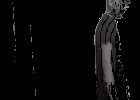

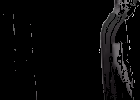

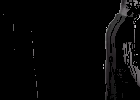

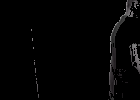

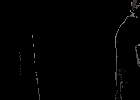

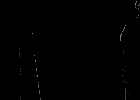

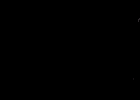

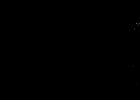

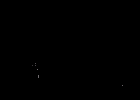

In [15]:
for i in range(num_frames):
  data = im.fromarray(results[i],'RGB')
  display(data)
  print()

In [20]:
if not os.path.isdir("Output"):
  os.mkdir("Output")
for i in range(num_frames):
  out = results[i]
  cv2.imwrite(os.path.join("Output", f"output{str(i)}.jpg"),out)

In [16]:
bg_sub = cv2.createBackgroundSubtractorMOG2();

result_inbuilt = []
for i in range(num_frames):
  img = bg_sub.apply(frames[i])
  result_inbuilt.append(img)

In [17]:
from google.colab.patches import cv2_imshow

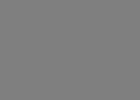

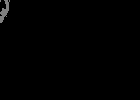

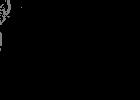

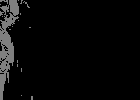

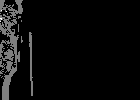

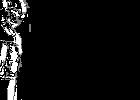

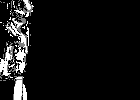

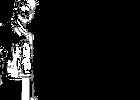

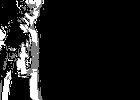

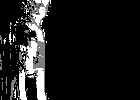

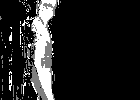

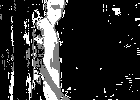

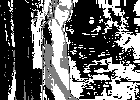

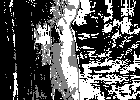

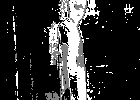

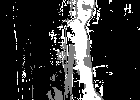

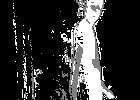

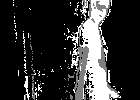

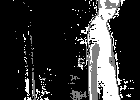

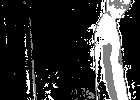

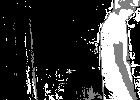

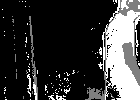

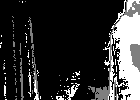

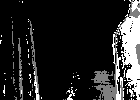

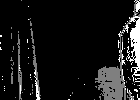

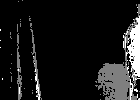

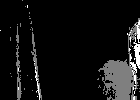

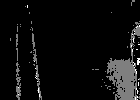

In [18]:
for i in range(num_frames):
  cv2_imshow(result_inbuilt[i])
  print()

In [19]:
def RMSE(y_actual, y_predicted):
  MSE = np.square(np.subtract(y_actual,y_predicted)).mean()
  return math.sqrt(MSE) 

In [21]:
MIN_RMSE = 100
MAX_RMSE = 0

res = []
for ind in range(num_frames):
  img = frames[ind]
  a = np.zeros((ROW,COL))
  for i in range(ROW):
    for j in range(COL):
      #a[i][j] = (img[i][j][0] + img[i][j][1] + img[i][j][2])/3
      #0.299R + 0.587G + 0.114B.
      a[i][j] = 0.299*img[i][j][0] + 0.587*img[i][j][1] + 0.114*img[i][j][2]
  res.append(a)

for i in range(num_frames):

  rmse = RMSE(result_inbuilt[i],res[i])
  MIN_RMSE = min(MIN_RMSE,rmse)
  MAX_RMSE = max(MAX_RMSE,rmse)

print("Minimum RMSE between our GMM and inbuilt function for background subtraction: {0:.2f}".format(MIN_RMSE))
print("Maximum RMSE between our GMM and inbuilt function for background subtraction: {0:.2f}".format(MAX_RMSE))

Minimum RMSE between our GMM and inbuilt function for background subtraction: 46.68
Maximum RMSE between our GMM and inbuilt function for background subtraction: 155.23
